## Import Relevant Libraries

In [ ]:
!pip install darts yfinance

In [2]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller


import yfinance as yf

## Data Pre-Processing

In [3]:
#Getting date from one year ago
one_year_ago = datetime.now() - relativedelta(years=1)
one_year_ago = one_year_ago.strftime("%Y-%m-%d")

#Getting date today
today = datetime.now()
today = today.strftime("%Y-%m-%d")

#Adding one day to the date one year ago
one_year_ago_plus_one = datetime.now() - relativedelta(years=1) + timedelta(days=1)
one_year_ago_plus_one = one_year_ago_plus_one.strftime("%Y-%m-%d")
four_years_ago = datetime.now() - relativedelta(years=4)
four_years_ago = four_years_ago.strftime("%Y-%m-%d")
print(four_years_ago)
print(today)
#Accessing YFinance
ticker= yf.Ticker("adbe")

#Getting pandas dataframe of stock data from one year ago
df = ticker.history(start=one_year_ago, end=today, interval="1d")
print(df)
idx = pd.date_range(start=one_year_ago_plus_one, end=today)
# print(idx)



#Making index into Datetime index
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.tz_localize(None)

#Reindexing dataframe to fill in missing dates due to stock market closing on weekends
df = df.reindex(idx, method = 'pad')


print(df)
print(len(df))



2019-06-27
2023-06-27
                                 Open        High         Low       Close  \
Date                                                                        
2022-06-27 00:00:00-04:00  388.799988  389.390015  379.380005  381.070007   
2022-06-28 00:00:00-04:00  381.000000  382.980011  364.450012  365.630005   
2022-06-29 00:00:00-04:00  367.940002  370.369995  362.640015  368.500000   
2022-06-30 00:00:00-04:00  362.899994  370.420013  357.559998  366.059998   
2022-07-01 00:00:00-04:00  364.179993  369.529999  359.070007  368.480011   
...                               ...         ...         ...         ...   
2023-06-20 00:00:00-04:00  485.630005  492.690002  480.000000  485.859985   
2023-06-21 00:00:00-04:00  492.000000  495.549988  475.309998  477.480011   
2023-06-22 00:00:00-04:00  474.119995  481.000000  473.019989  477.579987   
2023-06-23 00:00:00-04:00  472.950012  487.329987  472.320007  484.720001   
2023-06-26 00:00:00-04:00  483.010010  487.160004  479

In [4]:
#Put dataframe into a Darts "Timeseries" object so that data can be fed into a Darts forecasting model. For more information on Timeseries objects, please look here: https://unit8co.github.io/darts/generated_api/darts.timeseries.html
series = TimeSeries.from_dataframe(df)

#Drop all columns besides "Close" Column
#adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
adj_series = series.drop_columns(['Open','High','Low','Volume', 'Dividends', 'Stock Splits'])
print(adj_series[-1])

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[479.51000977]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-06-27
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


Text(0.5, 1.0, 'Training and Validation Plots')

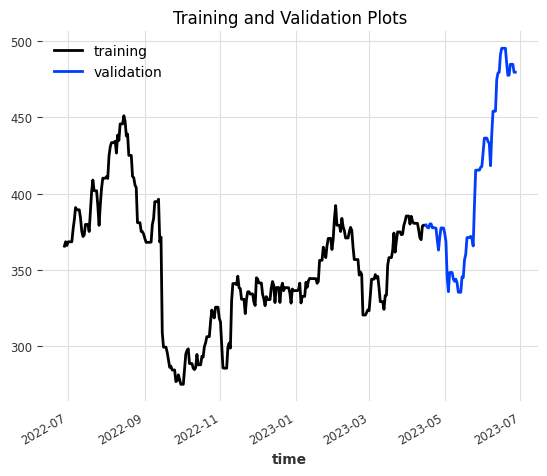

In [5]:

#Divide dataset into training and validation/testing sets. "Split_after" function is a method of a Darts Timeseries object. https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.split_after
training, validation = adj_series.split_after(0.8)

#Plot training and testing data
training.plot(label='training')
validation.plot(label='validation')
plt.legend();
plt.title("Training and Validation Plots")

In [6]:
#Transform training set, validation set, and entire series to values between 0 and 1.
transformer = Scaler()
train_transformed = transformer.fit_transform(training)
val_transformed = transformer.transform(validation)


## Construct LSTM Model in Darts

In [7]:
#Define LSTM Model
my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = 4, # Number of LSTM layers
    hidden_dim=10,
    dropout=0.06,
    batch_size=31,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3}, #learning rate
    model_name="Stock_Forecast",
    log_tensorboard=False,
    training_length=30,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

#Fit model on training data
my_model.fit(train_transformed)

#Predict values
pred = my_model.predict(n=len(val_transformed))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | V             | Linear           | 11    
---------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

## Evaluating Results

MAPE = 40.25%


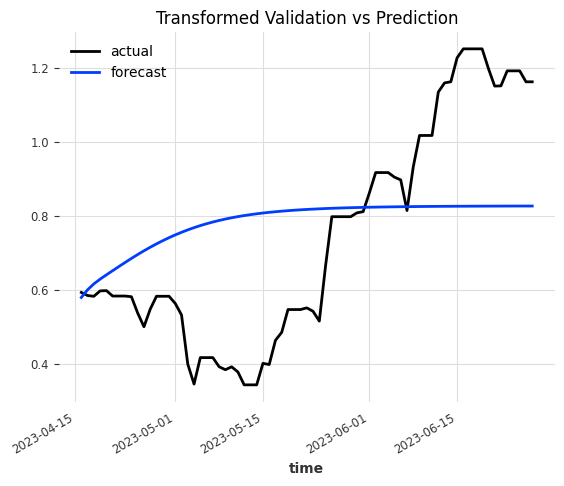

In [8]:
#Plot transformed validation set vs prediction
val_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
plt.title("Transformed Validation vs Prediction")
print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))


<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[420.46462076]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-06-27
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
420.46462075913934
MAPE = 10.45%


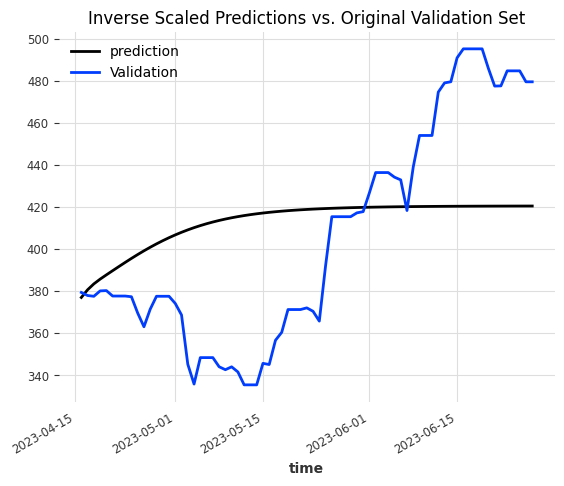

In [9]:
#Perform inverse scaling on prediction
inverse_scaler_pred = transformer.inverse_transform(pred)
print(inverse_scaler_pred[-1])


last_value_from_pred = TimeSeries.pd_dataframe(inverse_scaler_pred)["Close"][-1]
print(last_value_from_pred)

#Plot inverse scaled predictions with validation
inverse_scaler_pred.plot(label='prediction')
validation.plot(label='Validation')
plt.legend();
plt.title("Inverse Scaled Predictions vs. Original Validation Set")
print('MAPE = {:.2f}%'.format(mape(validation, inverse_scaler_pred)))

MAPE = 10.45%


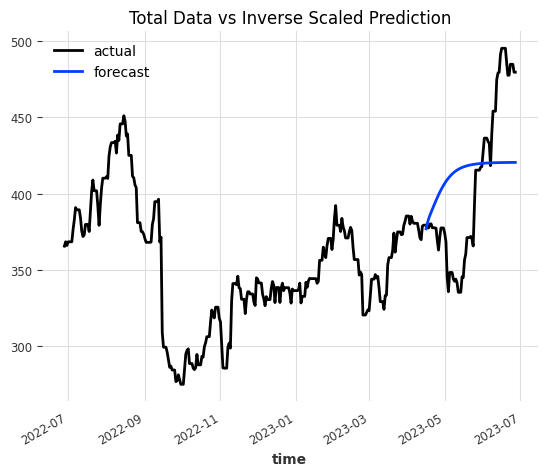

In [10]:
#Plot total data vs prediction
adj_series.plot(label='actual')
inverse_scaler_pred.plot(label='forecast')
plt.legend();
plt.title("Total Data vs Inverse Scaled Prediction")
print('MAPE = {:.2f}%'.format(mape(adj_series, inverse_scaler_pred)))